In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.nn.init as init
from torch.autograd import Variable
import scipy.io as sio
import torch.utils.data as Data

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(5, 64, kernel_size=17, padding=8)
        init.xavier_uniform_(self.conv1.weight)
        self.conv_bn1 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3520, 1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=17, padding=8)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=17, padding=8)
        self.conv_bn2 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 128, kernel_size=17, padding=8)
        self.conv5 = nn.Conv1d(128, 192, kernel_size=17, padding=8)
        self.conv_bn3 = nn.BatchNorm1d(192)
        self.conv6 = nn.Conv1d(192, 192, kernel_size=17, padding=8)

    def forward(self, x, hidden=None):
        x = F.relu(self.conv_bn1(self.conv1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.conv_bn1(self.conv2(x)))
        x = self.dropout(x)
        
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv_bn1(self.conv2(x)))
        x = self.dropout(x)
        
#         x = F.relu(self.conv_bn2(self.conv3(x)))
#         x = self.dropout(x)
        
#         x = self.conv4(x)
#         x = F.max_pool1d(x, 2)
#         x = F.relu(self.conv_bn2(x))
#         x = self.dropout(x)
        
#         x = F.relu(self.conv_bn3(self.conv5(x)))
#         x = self.dropout(x)
        
#         x = self.conv6(x)
#         x = F.max_pool1d(x, 2)
#         x = F.relu(self.conv_bn3(x))
#         x = self.dropout(x)
# #         print(x)
        
#         print(x.size())
        x = x.view(-1, 3520)
#         print(x.size())
        x = self.fc1(x)
#         print(x.size())
        return F.tanh(x)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Net().to(device)
#model = model.cuda()

In [6]:
summary(model, (5, 110))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 110]           5,504
       BatchNorm1d-2              [-1, 64, 110]             128
           Dropout-3              [-1, 64, 110]               0
            Conv1d-4              [-1, 64, 110]          69,696
       BatchNorm1d-5              [-1, 64, 110]             128
           Dropout-6              [-1, 64, 110]               0
            Conv1d-7               [-1, 64, 55]          69,696
       BatchNorm1d-8               [-1, 64, 55]             128
           Dropout-9               [-1, 64, 55]               0
           Linear-10                    [-1, 1]           3,521
Total params: 148,801
Trainable params: 148,801
Non-trainable params: 0
----------------------------------------------------------------


/Users/xufanxiong/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [7]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-6, weight_decay=1e-4)

In [8]:
dataset = sio.loadmat('fft_train_1.mat')
Y_train = dataset['Y_train']
Y_train = (Y_train - 50) / 150
X_train = dataset['X_trainB'].transpose(0, 2, 1)
print(Y_train.shape)
print(X_train.shape)
x_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(Y_train).float()
torch_train = Data.TensorDataset(x_train, y_train)
train_loader = Data.DataLoader(dataset=torch_train,
                              batch_size=128,
                              shuffle=True,
                              num_workers=2)

(3055, 1)
(3055, 5, 110)


In [17]:
import matplotlib.pyplot as plt

In [36]:
a = X_train.transpose(0, 2, 1)

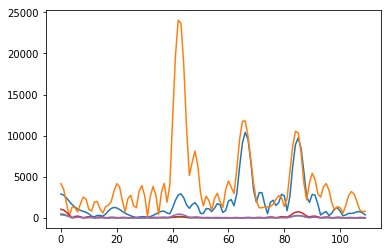

In [37]:
plt.plot(a[1, :, :])

In [46]:
import numpy as np
def normali(input):
	'''
	This function aim to normalize X_train
	'''
	for i in range(input.shape[2]):
		tem = input[:, :, i]
		tem = tem/(np.max(tem) - np.min(tem))
		input[:, :, i] = tem
	return input

In [47]:
a = normali(a)

In [49]:
a = a.transpose(0, 2, 1)

In [50]:
x_train = torch.from_numpy(a).float()
y_train = torch.from_numpy(Y_train).float()
torch_train = Data.TensorDataset(x_train, y_train)
train_loader = Data.DataLoader(dataset=torch_train,
                              batch_size=128,
                              shuffle=True,
                              num_workers=2)

In [52]:
dataset = sio.loadmat('fft_test_1.mat')
Y_test = dataset['Y_test']
Y_test = (Y_test - 50) / 150
X_test = dataset['X_testB']
X_test = normali(X_test)
X_test = X_test.transpose(0, 2, 1)
print(Y_test.shape)
print(X_test.shape)
x_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(Y_test).float()
torch_test = Data.TensorDataset(x_test, y_test)
test_loader = Data.DataLoader(dataset=torch_test,
                              batch_size=148,
                              shuffle=True,
                              num_workers=2)

(148, 1)
(148, 5, 110)


In [54]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        criterion = nn.MSELoss()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
#         if batch_idx % 5 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                     epoch, batch_idx*len(data), len(train_loader.dataset),
#                     100.*batch_idx / len(train_loader), loss.data[0]))

In [55]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        criterion = nn.MSELoss()
        test_loss = criterion(output, target)
        
    print('testing loss: ', test_loss)
    print(output)

In [56]:
for epoch in range(10):
    train(epoch)
    test()

/Users/xufanxiong/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


testing loss:  tensor(0.0674, grad_fn=<MseLossBackward>)
tensor([[0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
        [0.3920],
       

testing loss:  tensor(0.0366, grad_fn=<MseLossBackward>)
tensor([[0.5733],
        [0.5756],
        [0.5569],
        [0.5623],
        [0.5184],
        [0.5631],
        [0.5701],
        [0.5183],
        [0.5603],
        [0.5802],
        [0.5653],
        [0.5613],
        [0.5199],
        [0.5718],
        [0.5728],
        [0.5080],
        [0.5602],
        [0.5738],
        [0.5203],
        [0.5404],
        [0.5739],
        [0.5168],
        [0.5586],
        [0.5547],
        [0.5642],
        [0.5717],
        [0.5970],
        [0.5481],
        [0.5660],
        [0.5494],
        [0.5662],
        [0.5676],
        [0.5660],
        [0.5644],
        [0.5412],
        [0.5867],
        [0.6033],
        [0.5554],
        [0.5823],
        [0.5590],
        [0.5610],
        [0.5951],
        [0.6000],
        [0.5558],
        [0.6025],
        [0.5443],
        [0.5929],
        [0.5526],
        [0.5797],
        [0.6076],
        [0.6085],
        [0.5506],
       

testing loss:  tensor(0.0359, grad_fn=<MseLossBackward>)
tensor([[0.6201],
        [0.6030],
        [0.5876],
        [0.5562],
        [0.5998],
        [0.6230],
        [0.5970],
        [0.6086],
        [0.5741],
        [0.6005],
        [0.5722],
        [0.5402],
        [0.5939],
        [0.6331],
        [0.6282],
        [0.5758],
        [0.5540],
        [0.5467],
        [0.5725],
        [0.5449],
        [0.6011],
        [0.6322],
        [0.5818],
        [0.6061],
        [0.5409],
        [0.5627],
        [0.5867],
        [0.6267],
        [0.5438],
        [0.6359],
        [0.5326],
        [0.5525],
        [0.5824],
        [0.5898],
        [0.5933],
        [0.6380],
        [0.5515],
        [0.6205],
        [0.6332],
        [0.5826],
        [0.5879],
        [0.5961],
        [0.5822],
        [0.5439],
        [0.5665],
        [0.5558],
        [0.5783],
        [0.6339],
        [0.6153],
        [0.5874],
        [0.6196],
        [0.5378],
       

testing loss:  tensor(0.0402, grad_fn=<MseLossBackward>)
tensor([[0.5069],
        [0.5608],
        [0.5183],
        [0.5100],
        [0.5474],
        [0.5452],
        [0.5020],
        [0.5204],
        [0.5206],
        [0.5561],
        [0.5061],
        [0.5038],
        [0.4897],
        [0.5231],
        [0.5036],
        [0.4886],
        [0.4718],
        [0.4626],
        [0.4956],
        [0.4915],
        [0.5763],
        [0.5097],
        [0.4923],
        [0.4847],
        [0.4520],
        [0.5793],
        [0.4942],
        [0.5207],
        [0.5610],
        [0.5256],
        [0.5385],
        [0.5274],
        [0.5524],
        [0.4992],
        [0.5183],
        [0.5149],
        [0.4880],
        [0.5718],
        [0.5111],
        [0.4827],
        [0.5329],
        [0.5305],
        [0.5415],
        [0.4821],
        [0.5120],
        [0.4692],
        [0.4875],
        [0.4991],
        [0.5218],
        [0.5284],
        [0.5766],
        [0.4822],
       

In [13]:
# test11()